    ** This notebook consist of my work to understand and implement image classification using state-of-the-art vision transformer technique on Mal-Image Dataset 

    ** Task-1 
        i.   successfully load all images 
        ii.  convert images to matrix

# Load Libraries 

In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import tensorflow_addons as tfa

In [2]:
tf.config.experimental.set_memory_growth(
    tf.config.list_physical_devices("GPU")[0], True)

In [3]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [4]:
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings("ignore")

In [5]:
from sklearn.model_selection import train_test_split

#### Check on GPU Support 

In [6]:
if tf.test.gpu_device_name():
    print('Default GPU Device:{}'.format(tf.test.gpu_device_name()))
    print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))
    print("is_built_with_gpu_support :- ",tf.test.is_built_with_gpu_support())
    print("is_built_with_cuda :- ",tf.test.is_built_with_cuda())
    print(tf.config.list_physical_devices('GPU'))
else:
    print("No GPU Found !!!!")

Default GPU Device:/device:GPU:0
Num GPUs Available:  1
is_built_with_gpu_support :-  True
is_built_with_cuda :-  True
[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


# Load Data

    ** Setting up image size to be same for all images in the data-set

## Image --> Matrix

In [7]:
batches = ImageDataGenerator().flow_from_directory(
    directory=
    'D:\\Work_Space\\Data-Sets\\malimg_dataset\\malimg_paper_dataset_imgs',
    color_mode='grayscale',
    target_size=(64, 64),
    batch_size=10000,
    seed=9,
)

Found 9339 images belonging to 25 classes.


In [8]:
batches.class_indices

{'Adialer.C': 0,
 'Agent.FYI': 1,
 'Allaple.A': 2,
 'Allaple.L': 3,
 'Alueron.gen!J': 4,
 'Autorun.K': 5,
 'C2LOP.P': 6,
 'C2LOP.gen!g': 7,
 'Dialplatform.B': 8,
 'Dontovo.A': 9,
 'Fakerean': 10,
 'Instantaccess': 11,
 'Lolyda.AA1': 12,
 'Lolyda.AA2': 13,
 'Lolyda.AA3': 14,
 'Lolyda.AT': 15,
 'Malex.gen!J': 16,
 'Obfuscator.AD': 17,
 'Rbot!gen': 18,
 'Skintrim.N': 19,
 'Swizzor.gen!E': 20,
 'Swizzor.gen!I': 21,
 'VB.AT': 22,
 'Wintrim.BX': 23,
 'Yuner.A': 24}

In [9]:
imgs,labels = next(batches)

In [10]:
imgs.shape

(9339, 64, 64, 1)

In [11]:
labels.shape

(9339, 25)

## Visualize Data  

In [75]:
def plots(ims, figsize=(20, 30), rows=10, cols=10, titles=None):
    if type(ims[0]) is np.ndarray:
        ims = np.array(ims).astype(np.uint8)
    f = plt.figure(figsize=figsize)
    for i in range(0, 50):
        sp = f.add_subplot(rows, cols, i + 1)
        sp.axis('Off')
        if titles is not None:
            sp.set_title(list(batches.class_indices.keys())[np.argmax(
                titles[i])],
                         fontsize=16)
        plt.imshow(ims[i], cmap='gray', vmin=0, vmax=255)

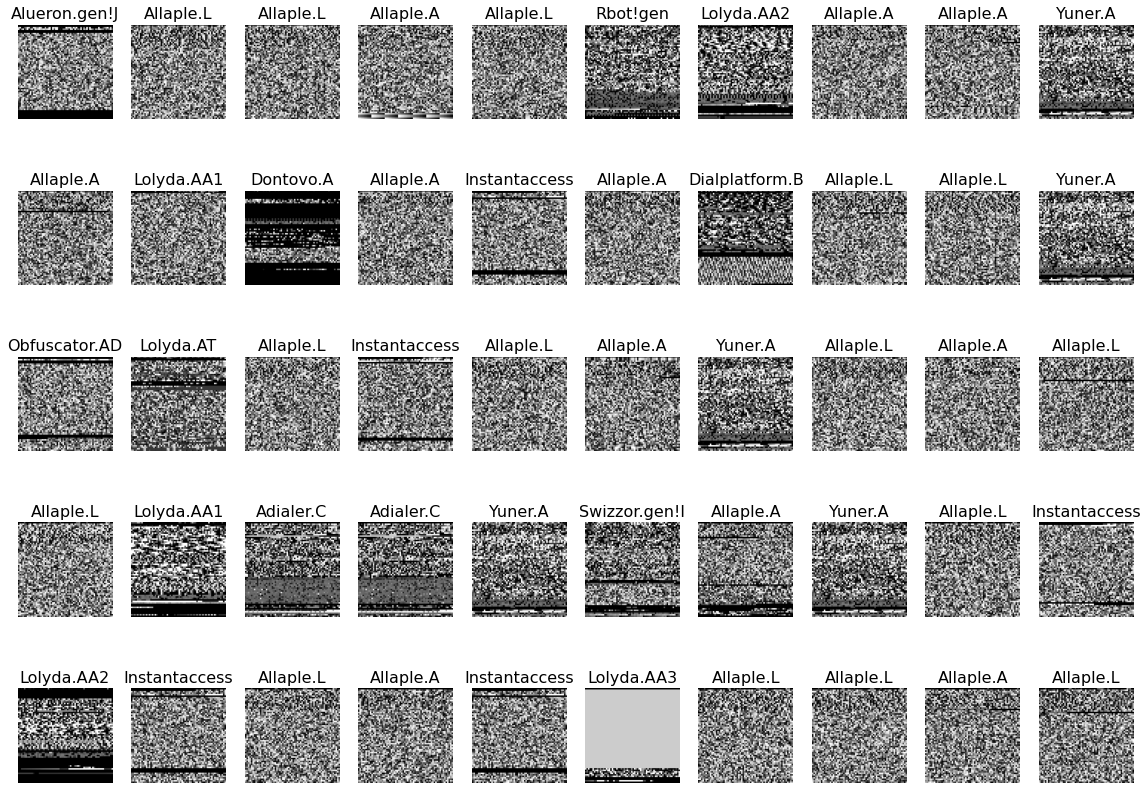

In [76]:
plots(imgs,titles=labels)

<BarContainer object of 25 artists>

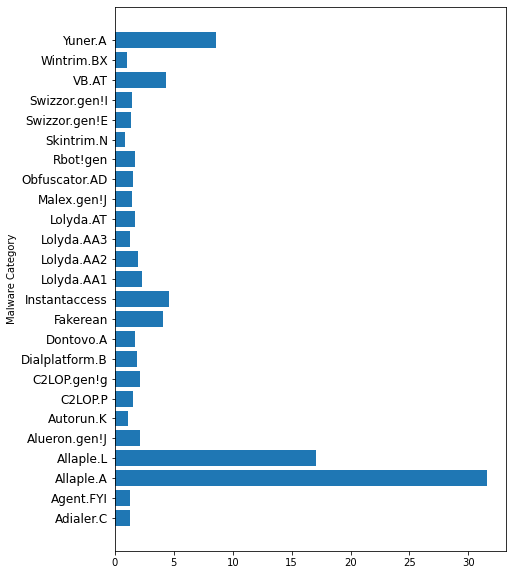

In [121]:
plt.figure(figsize=(7, 10))
plt.yticks(rotation='horizontal')
plt.ylabel('Malware Category',fontsize=10)
plt.rc('ytick',labelsize=12)
plt.barh(list(batches.class_indices.keys()),[x for x in ((sum(labels) / labels.shape[0]) * 100)])

![alt text](types_of_malware_malimg.png "Malware Category")

## Train-Test Split 

In [12]:
scaled_imgs = imgs/255

In [13]:
X_train,X_test,Y_train,Y_test = train_test_split(scaled_imgs,labels, test_size=0.3)

In [125]:
%whos

Variable             Type                          Data/Info
------------------------------------------------------------
ImageDataGenerator   type                          <class 'tensorflow.python<...>mage.ImageDataGenerator'>
NamespaceMagics      MetaHasTraits                 <class 'IPython.core.magi<...>mespace.NamespaceMagics'>
X_test               ndarray                       2802x64x64x1: 11476992 elems, type `float32`, 45907968 bytes (43.78125 Mb)
X_train              ndarray                       6537x64x64x1: 26775552 elems, type `float32`, 107102208 bytes (102.140625 Mb)
Y_test               ndarray                       2802x25: 70050 elems, type `float32`, 280200 bytes (273.6328125 kb)
Y_train              ndarray                       6537x25: 163425 elems, type `float32`, 653700 bytes (638.37890625 kb)
autopep8             module                        <module 'autopep8' from '<...>e-packages\\autopep8.py'>
get_ipython          function                      <function g

    ** Data Augmentation :- 
    
        i.  Make data augmentation part of the modeling process pros to this is while doing this we can leverage the power
            of GPU
        ii. Keep this process outside of the modeling process and in data pre-processing step pros to it is we can save the
            data separately cons to its ** calculation will happen on CPU **  

    ** I choose the 1st approach

# Configure Hyper Space 

In [14]:
image_size = 64
patch_size = 6
num_patches = (image_size // patch_size)**2
projection_dim = 64
no_heads = 4
transformer_units = [projection_dim * 2, projection_dim]
transformer_layers = 8
mlp_head_units = [2048, 1024]

# Data Augmentation

In [15]:
data_augmentation = keras.Sequential(
    [
        layers.experimental.preprocessing.Normalization(),
        layers.experimental.preprocessing.Resizing(image_size, image_size),
        layers.experimental.preprocessing.RandomFlip("horizontal"),
        layers.experimental.preprocessing.RandomRotation(factor=0.02),
        layers.experimental.preprocessing.RandomZoom(height_factor=0.2,
                                                     width_factor=0.2),
    ],
    name="data_augmentation",
)
data_augmentation.layers[0].adapt(X_train)

# MLP

In [16]:
def mlp(x, hidden_units, dropout_rate):
    for units in hidden_units:
        x = layers.Dense(units, activation=tf.nn.gelu)(x)
        x = layers.Dropout(dropout_rate)(x)
    return x

# Patch Creation 

In [17]:
class Patches(layers.Layer):
    def __init__(self, patch_size):
        super(Patches, self).__init__()
        self.patch_size = patch_size

    def call(self, images):
        batch_size = tf.shape(images)[0]
        patches = tf.image.extract_patches(
            images=images,
            sizes=[1, self.patch_size, self.patch_size, 1],
            strides=[1, self.patch_size, self.patch_size, 1],
            rates=[1, 1, 1, 1],
            padding="VALID",
        )
        patch_dims = patches.shape[-1]
        patches = tf.reshape(patches, [batch_size, -1, patch_dims])
        return patches

Image size: 64 X 64
Patch size: 6 X 6
Patches per image: 100
Elements per patch: 36


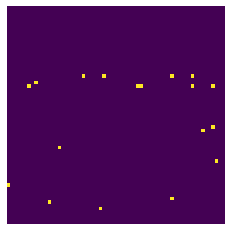

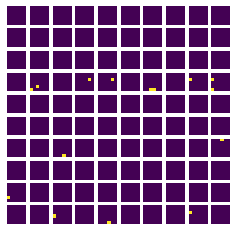

In [18]:
plt.figure(figsize=(4, 4))
image = X_train[np.random.choice(range(X_train.shape[0]))]
plt.imshow(image.astype("uint8"))
plt.axis("off")
resized_image = tf.image.resize(tf.convert_to_tensor([image]),
                                size=(image_size, image_size))
patches = Patches(patch_size)(resized_image)
print(f"Image size: {image_size} X {image_size}")
print(f"Patch size: {patch_size} X {patch_size}")
print(f"Patches per image: {patches.shape[1]}")
print(f"Elements per patch: {patches.shape[-1]}")
n = int(np.sqrt(patches.shape[1]))
plt.figure(figsize=(4, 4))
for i, patch in enumerate(patches[0]):
    ax = plt.subplot(n, n, i + 1)
    patch_img = tf.reshape(patch, (patch_size, patch_size, 1))
    plt.imshow(patch_img.numpy().astype("uint8"))
    plt.axis("off")

# Patch Encoding Layer

In [19]:
class PatchEncoder(layers.Layer):
    def __init__(self, num_patches, projection_dim):
        super(PatchEncoder, self).__init__()
        self.num_patches = num_patches
        self.projection = layers.Dense(units=projection_dim)
        self.position_embedding = layers.Embedding(input_dim=num_patches,
                                                   output_dim=projection_dim)

    def call(self, patch):
        positions = tf.range(start=0, limit=self.num_patches, delta=1)
        encoded = self.projection(patch) + self.position_embedding(positions)
        return encoded

# Class Weight 

In [20]:
from sklearn.utils import class_weight
class_weights = class_weight.compute_class_weight(
    'balanced',
    np.unique(np.argmax(Y_train, axis=1)).tolist(), np.argmax(Y_train, axis=1))

In [21]:
np.argmax(Y_train, axis=1).shape

(6537,)

In [22]:
{
    k: v
    for (k, v) in zip(
        np.unique(np.argmax(Y_train, axis=1)).tolist(), class_weights)
}

{0: 2.8734065934065933,
 1: 3.352307692307692,
 2: 0.12650217706821482,
 3: 0.2357799819657349,
 4: 1.9368888888888889,
 5: 3.581917808219178,
 6: 2.72375,
 7: 1.8811510791366906,
 8: 2.0588976377952757,
 9: 2.1432786885245902,
 10: 0.943971119133574,
 11: 0.8954794520547945,
 12: 1.720263157894737,
 13: 1.9513432835820896,
 14: 3.1503614457831324,
 15: 2.1973109243697477,
 16: 2.7817021276595746,
 17: 2.641212121212121,
 18: 2.4667924528301888,
 19: 5.127058823529412,
 20: 3.1503614457831324,
 21: 2.8734065934065933,
 22: 0.9110801393728223,
 23: 3.8452941176470588,
 24: 0.46361702127659576}

# Visual Transformer (ViT)

In [31]:
def create_vit_classifier():
    inputs = layers.Input(shape=(64, 64, 1))
    # Augment data.
    augmented = data_augmentation(inputs)
    # Create patches.
    patches = Patches(patch_size)(augmented)
    # Encode patches.
    encoded_patches = PatchEncoder(num_patches, projection_dim)(patches)

    # Create multiple layers of the Transformer block.
    for _ in range(transformer_layers):
        # Layer normalization 1.
        x1 = layers.LayerNormalization(epsilon=1e-6)(encoded_patches)
        # Create a multi-head attention layer.
        attention_output = layers.MultiHeadAttention(num_heads=no_heads,
                                                     key_dim=projection_dim,
                                                     dropout=0.1)(x1, x1)
        # Skip connection 1.
        x2 = layers.Add()([attention_output, encoded_patches])
        # Layer normalization 2.
        x3 = layers.LayerNormalization(epsilon=1e-6)(x2)
        # MLP.
        x3 = mlp(x3, hidden_units=transformer_units, dropout_rate=0.1)
        # Skip connection 2.
        encoded_patches = layers.Add()([x3, x2])

    # Create a [batch_size, projection_dim] tensor.
    representation = layers.LayerNormalization(epsilon=1e-6)(encoded_patches)
    representation = layers.Flatten()(representation)
    representation = layers.Dropout(0.5)(representation)
    # Add MLP.
    features = mlp(representation,
                   hidden_units=mlp_head_units,
                   dropout_rate=0.5)
    # Classify outputs.
    logits = layers.Dense(25, activation='softmax')(features)
    # Create the Keras model.
    model = keras.Model(inputs=inputs, outputs=logits)
    return model

In [32]:
model = create_vit_classifier()

In [33]:
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 64, 64, 1)]  0                                            
__________________________________________________________________________________________________
data_augmentation (Sequential)  (None, 64, 64, 1)    3           input_2[0][0]                    
__________________________________________________________________________________________________
patches_2 (Patches)             (None, None, 36)     0           data_augmentation[1][0]          
__________________________________________________________________________________________________
patch_encoder_1 (PatchEncoder)  (None, 100, 64)      8768        patches_2[0][0]                  
____________________________________________________________________________________________

In [34]:
model.compile(
    optimizer=tfa.optimizers.AdamW(learning_rate=0.0003,
                                   weight_decay=0.00001),
    loss='categorical_crossentropy',
    metrics=["acc"]
)

In [52]:
history = model.fit(
    x=X_train,
    y=Y_train,
    batch_size=32,
    epochs=100,
    validation_data=(X_test, Y_test),
    class_weight={
        k: v
        for (k, v) in zip(
            np.unique(np.argmax(Y_train, axis=1)).tolist(), class_weights)
    },
    use_multiprocessing=True)

Epoch 1/100
205/205 [==============================] - 18s 88ms/step - loss: 0.3653 - acc: 0.7202 - val_loss: 0.9412 - val_acc: 0.5128
Epoch 2/100
205/205 [==============================] - 21s 101ms/step - loss: 0.3323 - acc: 0.7471 - val_loss: 0.6765 - val_acc: 0.6403
Epoch 3/100
205/205 [==============================] - 17s 83ms/step - loss: 0.3215 - acc: 0.7242 - val_loss: 0.5622 - val_acc: 0.7206
Epoch 4/100
205/205 [==============================] - 16s 78ms/step - loss: 0.3263 - acc: 0.7444 - val_loss: 0.4679 - val_acc: 0.8244
Epoch 5/100
205/205 [==============================] - 16s 77ms/step - loss: 0.3261 - acc: 0.7386 - val_loss: 0.5039 - val_acc: 0.8084
Epoch 6/100
205/205 [==============================] - 17s 83ms/step - loss: 0.3182 - acc: 0.7321 - val_loss: 0.4719 - val_acc: 0.7602
Epoch 7/100
205/205 [==============================] - 17s 85ms/step - loss: 0.3010 - acc: 0.7510 - val_loss: 0.5949 - val_acc: 0.7355
Epoch 8/100
205/205 [==============================] -

205/205 [==============================] - 17s 85ms/step - loss: 0.1972 - acc: 0.8027 - val_loss: 0.4839 - val_acc: 0.8130
Epoch 62/100
205/205 [==============================] - 17s 84ms/step - loss: 0.2194 - acc: 0.8199 - val_loss: 0.7919 - val_acc: 0.6003
Epoch 63/100
205/205 [==============================] - 17s 85ms/step - loss: 0.2015 - acc: 0.7999 - val_loss: 0.3965 - val_acc: 0.7894
Epoch 64/100
205/205 [==============================] - 18s 86ms/step - loss: 0.2057 - acc: 0.8187 - val_loss: 0.5090 - val_acc: 0.7266
Epoch 65/100
205/205 [==============================] - 17s 81ms/step - loss: 0.1978 - acc: 0.8114 - val_loss: 0.4975 - val_acc: 0.8073
Epoch 66/100
205/205 [==============================] - 17s 84ms/step - loss: 0.2051 - acc: 0.8242 - val_loss: 0.5203 - val_acc: 0.7905
Epoch 67/100
205/205 [==============================] - 18s 86ms/step - loss: 0.1984 - acc: 0.8206 - val_loss: 0.5189 - val_acc: 0.7926
Epoch 68/100
205/205 [==============================] - 17s 8

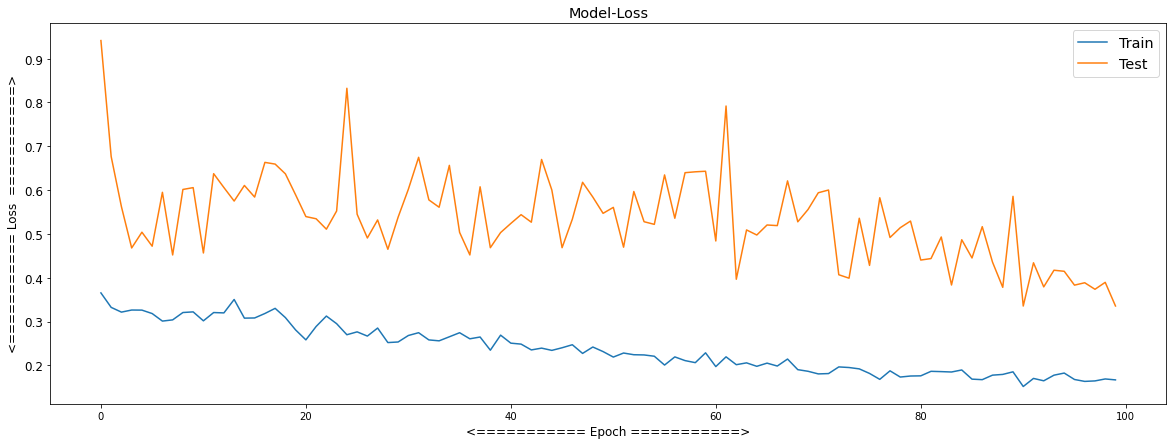

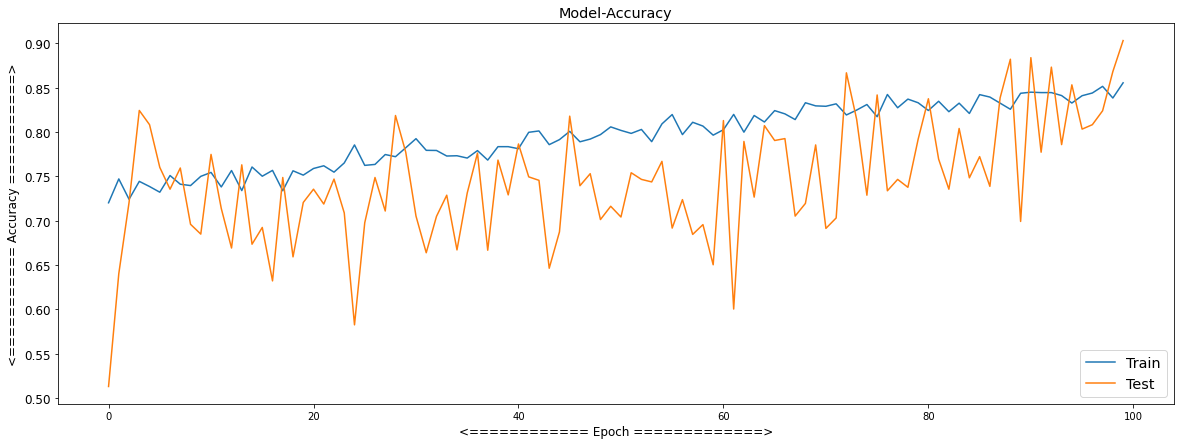

In [53]:
plt.figure(figsize=(20, 7))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model-Loss', fontsize='x-large')
plt.ylabel('<=========== Loss  ===========>', fontsize='large')
plt.xlabel('<=========== Epoch ===========>', fontsize='large')
plt.legend(['Train', 'Test'], loc='upper right', fontsize='x-large')
plt.rc('ytick', labelsize=12)
plt.show()
plt.figure(figsize=(20, 7))
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('Model-Accuracy', fontsize='x-large')
plt.ylabel('<=========== Accuracy ===========>', fontsize='large')
plt.xlabel('<============ Epoch =============>', fontsize='large')
plt.legend(['Train', 'Test'], fontsize='x-large', loc='lower right')
plt.show()

# Model Evaluate 

## Evaluate Method

In [49]:
import pycm


def evaluate_model(Y_actual, Y_predicted):

    confusion_matrix_class = pycm.ConfusionMatrix(actual_vector=Y_actual,
                                                  predict_vector=Y_predicted)

    TPR = []
    PPV = []
    FPR = []
    FNR = []
    ACC = []
    F1 = []

    FP = confusion_matrix_class.FP.values()
    FN = confusion_matrix_class.FN.values()
    TP = confusion_matrix_class.TP.values()
    TN = confusion_matrix_class.TN.values()

    FPR_ = (sum(FP) / (sum(FP) + sum(TN)))
    FNR_ = (sum(FN) / (sum(FN) + sum(TP)))

    ACC_ = ((sum(TP) + sum(TN)) / (sum(FN) + sum(TP) + sum(TN) + sum(FP)))

    TPR.append(
        np.where((confusion_matrix_class.overall_stat['TPR Micro'] == 'None') |
                 (confusion_matrix_class.overall_stat['TPR Micro'] == np.nan),
                 -0.99, confusion_matrix_class.overall_stat['TPR Micro']))
    PPV.append(
        np.where((confusion_matrix_class.overall_stat['PPV Micro'] == 'None') |
                 (confusion_matrix_class.overall_stat['PPV Micro'] == np.nan),
                 -0.99, confusion_matrix_class.overall_stat['PPV Micro']))

    FPR.append(round(FPR_, 4))
    FNR.append(round(FNR_, 4))
    ACC.append(round(ACC_, 4))

    F1.append(
        np.where((confusion_matrix_class.overall_stat['F1 Micro'] == 'None') |
                 (confusion_matrix_class.overall_stat['F1 Micro'] == np.nan),
                 -0.99, confusion_matrix_class.overall_stat['F1 Micro']))

    for i in confusion_matrix_class.classes:

        TPR.append(
            round(
                float(
                    np.where(
                        (confusion_matrix_class.class_stat['TPR'][i] == 'None')
                        | (confusion_matrix_class.class_stat['TPR'][i]
                           == np.nan), -0.99,
                        confusion_matrix_class.class_stat['TPR'][i])), 4))

        PPV.append(
            round(
                float(
                    np.where(
                        (confusion_matrix_class.class_stat['PPV'][i] == 'None')
                        | (confusion_matrix_class.class_stat['PPV'][i]
                           == np.nan), -0.99,
                        confusion_matrix_class.class_stat['PPV'][i])), 4))

        FPR.append(
            round(
                float(
                    np.where(
                        (confusion_matrix_class.class_stat['FPR'][i] == 'None')
                        | (confusion_matrix_class.class_stat['FPR'][i]
                           == np.nan), -0.99,
                        confusion_matrix_class.class_stat['FPR'][i])), 4))
        FNR.append(
            round(
                float(
                    np.where(
                        (confusion_matrix_class.class_stat['FNR'][i] == 'None')
                        | (confusion_matrix_class.class_stat['FNR'][i]
                           == np.nan), -0.99,
                        confusion_matrix_class.class_stat['FNR'][i])), 4))

        ACC.append(
            round(
                float(
                    np.where(
                        (confusion_matrix_class.class_stat['ACC'][i] == 'None')
                        | (confusion_matrix_class.class_stat['ACC'][i]
                           == np.nan), -0.99,
                        confusion_matrix_class.class_stat['ACC'][i])), 4))
        F1.append(
            round(
                float(
                    np.where(
                        (confusion_matrix_class.class_stat['F1'][i] == 'None')
                        |
                        (confusion_matrix_class.class_stat['F1'][i] == np.nan),
                        -0.99, confusion_matrix_class.class_stat['F1'][i])),
                4))

    eval_df = pd.DataFrame()
    index = ['overall']
    index.extend(confusion_matrix_class.classes)
    eval_df['Reccall'] = TPR
    eval_df['Precision'] = PPV
    eval_df['False_Positive_Rate'] = FPR
    eval_df['False_Negative_Rate'] = FNR
    eval_df['Accuracy'] = ACC
    eval_df['F1_Score'] = F1
    eval_df.index = index

    return (eval_df)

## Predict 

In [54]:
y_train_pred = model.predict(X_train, workers=-1, use_multiprocessing=True)
y_test_pred = model.predict(X_test, workers=-1, use_multiprocessing=True)

## Train

In [55]:
np.round(
    evaluate_model(
        np.argmax(Y_train, axis=1).tolist(),
        np.argmax(y_train_pred, axis=1).tolist()) * 100, 2)

,Reccall,Precision,False_Positive_Rate,False_Negative_Rate,Accuracy,F1_Score
overall,93.2691,93.2691,0.28,6.73,99.46,93.2691
0,100,100,0.00,0.00,100.00,100
1,100,100,0.00,0.00,100.00,100
2,90.47,92.71,3.29,9.53,94.74,91.58
3,86.11,95.6,0.81,13.89,96.97,90.61
4,99.26,85.9,0.34,0.74,99.65,92.1
5,0,-99,0.00,100.00,98.88,0
6,100,96,0.06,0.00,99.94,97.96
7,100,88.54,0.28,0.00,99.72,93.92
8,100,100,0.00,0.00,100.00,100


## Test 

In [56]:
np.round(
    evaluate_model(
        np.argmax(Y_test, axis=1).tolist(),
        np.argmax(y_test_pred, axis=1).tolist()) * 100, 2)

,Reccall,Precision,False_Positive_Rate,False_Negative_Rate,Accuracy,F1_Score
overall,90.3283,90.3283,0.40,9.67,99.23,90.3283
0,100,100,0.00,0.00,100.00,100
1,100,100,0.00,0.00,100.00,100
2,90.14,91.27,3.96,9.86,94.18,90.7
3,85.27,96.48,0.65,14.73,96.93,90.53
4,90.48,75,0.69,9.52,99.11,82.01
5,0,-99,0.00,100.00,98.82,0
6,80,83.33,0.29,20.00,99.36,81.63
7,93.44,67.86,0.99,6.56,98.89,78.62
8,100,100,0.00,0.00,100.00,100


# Model Dump & Load 